# Degree distributions

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import seaborn as sns

As we know, means of distributions do not always tell the entire story. For example, the distribution of the degrees of all the nodes in our Twitch network has some surprising features.

In [2]:
twitch = nx.read_edgelist("musae_edges.csv",delimiter=',',nodetype=int)
twitch_degrees = pd.Series(dict(twitch.degree),index=twitch.nodes)
twitch_degrees.describe()

count    7126.000000
mean        9.914117
std        22.190263
min         1.000000
25%         2.000000
50%         5.000000
75%        11.000000
max       720.000000
dtype: float64

Observe above that that there is a significant disparity between the mean and median values of the degree distribution, and that the standard deviation is much larger than the mean. A histogram plot confirms that the degree distribution is widely dispersed:

Twitch network degree distribution:


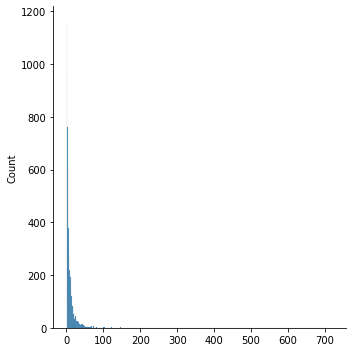

In [3]:
print("Twitch network degree distribution:")
sns.displot(data=twitch_degrees);

A few nodes in the network have hundreds of friends:

In [4]:
friend_counts = twitch_degrees.value_counts()  # histogram heights
friend_counts.sort_index(ascending=False)

720       1
691       1
465       1
378       1
352       1
       ... 
5       458
4       605
3       761
2       979
1      1161
Length: 130, dtype: int64

These "gregarious nodes" or *hubs* are characteristic of many social and other real-world networks.

We can compare the above distribution to that in a collection of ER graphs with the same size and expected average degree.

ER graphs degree distribution:


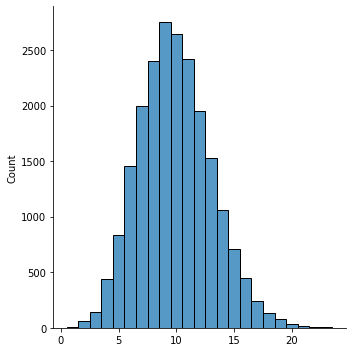

In [5]:
n,e = twitch.number_of_nodes(),twitch.number_of_edges()
kbar = 2*e/n
p = kbar/(n-1)
degrees = []
for iter in range(3):
    ER = nx.erdos_renyi_graph(n,p,seed=111+iter)
    degrees.extend([ER.degree(i) for i in ER.nodes])

print("ER graphs degree distribution:")
sns.displot(data=degrees,discrete=True);

Theory proves that the plot above converges to a *binomial distribution*. This is yet another indicator that the ER model does not explain the Twitch network well. A WS graph has a similar distribution:

WS graphs degree distribution:


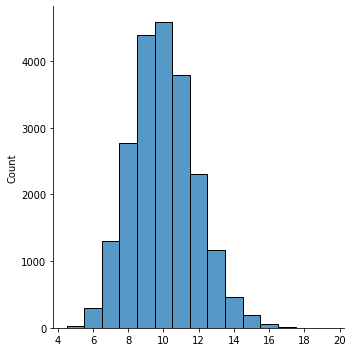

In [6]:
k,q = 10,0.42
degrees = []
for iter in range(3):
    WS = nx.watts_strogatz_graph(n,k,q,seed=222+iter)
    degrees.extend([WS.degree(i) for i in WS.nodes])

print("WS graphs degree distribution:")
sns.displot(data=degrees,discrete=True);

## Power-law distribution

The behavior of the Twitch degree distribution gets very interesting when the axes are transformed to use log scales:

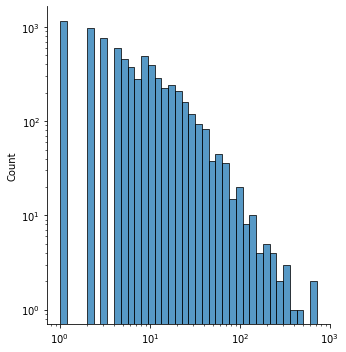

In [7]:
hist = sns.displot(data=twitch_degrees,log_scale=True)
hist.axes[0,0].set_yscale("log")

For degrees between 10 and several hundred, the counts lie nearly on a straight line. That is, if $x$ is degree and $y$ is the node count at that degree, then

$$
\log(y) \approx  - a\cdot \log(x) + b,
$$

i.e.,

$$
y \approx B x^{-a},
$$

for some $a > 0$. This relationship is known as a **power law**. Many social networks seem to follow a power-law distribution of node degrees, to some extent. (The precise extent is a subject of hot debate.)

Note that the decay of $x^{-a}$ to zero as $x\to\infty$ is much slower than, say, the normal distribution's $e^{-x^2/2}$, or even just an exponential $e^{-cx}$. This last comparison is how a *heavy-tailed distribution* is usually defined.

We can get a fair estimate of the constants $B$ and $a$ in the power law by doing a least-squares fit on the logs of $x$ and $y$. First, we need the counts:

In [8]:
y = twitch_degrees.value_counts()
counts = pd.DataFrame({"degree":y.index,"count":y.values})
counts = counts[(counts["degree"] > 10) & (counts["degree"] < 200)];
counts.head(6)

,degree,count
10,11,193
11,12,155
12,13,131
13,14,122
14,15,103
15,17,83


Now we will get additional columns by log transformations. (Note: the `np.log` function is the natural logarithm.)

In [9]:
logcounts = counts.transform(np.log)

Now we use `sklearn` for a linear regression.

In [10]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(logcounts[["degree"]],logcounts["count"])
lm.coef_[0],lm.intercept_

(-1.9941272617745713, 9.7094067609447)

The first value, which is both the slope of the line and the exponent of $x$ in the power law, is the most interesting part. It estimates that the degree counts vary as $Bx^{-2.1}$ over a wide range of degrees.

## Barabási–Albert graphs

A random **Barabási–Albert** graph (BA graph) is constructed by starting with a small seed network and connecting one node at a time with $m$ new edges to it. Edges are added randomly, but higher probability is given to connect to nodes that already have higher degree (i.e., are more "popular"), a concept known as *preferential attachment*. Because of this rule, there is a natural tendency to develop a few hubs of high degree.

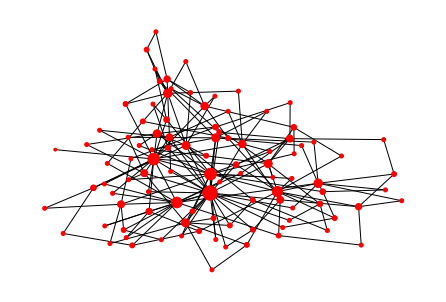

In [11]:
BA = nx.barabasi_albert_graph(100,2,seed=0)
BA_degrees = pd.Series(dict(BA.degree),index=BA.nodes)
nx.draw(BA,node_size=8*BA_degrees,node_color="red")

When we match these graphs to the size and average degree of the Twitch network, a power-law distribution emerges.
Since we add $m$ edges (almost) $n$ times, the expected average degree is $2mn/n=2m$. Therefore, in the BA construction we want to choose 

$$
m \approx \frac{\bar{k}}{2}. 
$$

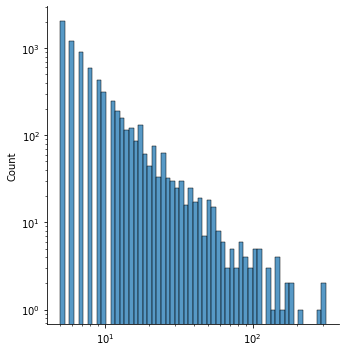

In [12]:
m = round(kbar/2)
BA = nx.barabasi_albert_graph(n,m,seed=5)
BA_degrees = pd.Series(dict(BA.degree),index=BA.nodes)
hist = sns.displot(data=BA_degrees,log_scale=True)
hist.axes[0,0].set_yscale("log")

Theory predicts that the exponent of the power-law distribution in a BA graph is $-3$.

In [13]:
y = BA_degrees.value_counts()
counts = pd.DataFrame({"degree":y.index,"count":y.values})
counts = counts[(counts["degree"] > 5) & (counts["degree"] < 80)];
logcounts = counts.transform(np.log)
lm.fit(logcounts[["degree"]],logcounts["count"])
print("exponent of power law:",lm.coef_[0])

exponent of power law: -2.8731368520629954


Let's check distances and clustering, too. As a reminder, the mean distance in the Twitch network is approximately:

In [14]:
from numpy.random import default_rng
rng = default_rng(1)

def pairdist(G):
    n = nx.number_of_nodes(G)
    i = j = rng.integers(0,n)
    while i==j: j=rng.integers(0,n)   # get distinct nodes
    return nx.shortest_path_length(G,source=i,target=j)

print("Mean distance in Twitch graph:",sum(pairdist(twitch) for _ in range(4000))/4000)

Mean distance in Twitch graph: 3.657


Now we repeat that for some BA graphs.

In [15]:
dbar = []
seed = 911
for iter in range(10):
    BA = nx.barabasi_albert_graph(n,m,seed=seed)
    d = sum(pairdist(BA) for _ in range(200))/200
    dbar.append(d)
    seed += 1

print("Mean distance in BA graphs:",np.mean(dbar))

Mean distance in BA graphs: 3.5555


Not bad! Now, let's check the clustering. For Twitch, we have:

In [16]:
print("Mean clustering in Twitch graph:",nx.average_clustering(twitch))

Mean clustering in Twitch graph: 0.13092821901472096


And for BA, we get

In [17]:
cbar = []
seed = 59
for iter in range(20):
    BA = nx.barabasi_albert_graph(n,m,seed=seed)
    cbar.append(nx.average_clustering(BA))
    seed += 1
    
print("Mean clustering in BA graphs:",np.mean(cbar))

Mean clustering in BA graphs: 0.009219743245252128


The BA model is our closest approach so far, but it fails to produce the close-knit neighbor subgraphs that we find in the Twitch network and the WS model.

<div style="max-width:608px"><div style="position:relative;padding-bottom:66.118421052632%"><iframe id="kaltura_player" src="https://cdnapisec.kaltura.com/p/2358381/sp/235838100/embedIframeJs/uiconf_id/43030021/partner_id/2358381?iframeembed=true&playerId=kaltura_player&entry_id=1_o7obnov2&flashvars[streamerType]=auto&amp;flashvars[localizationCode]=en&amp;flashvars[leadWithHTML5]=true&amp;flashvars[sideBarContainer.plugin]=true&amp;flashvars[sideBarContainer.position]=left&amp;flashvars[sideBarContainer.clickToClose]=true&amp;flashvars[chapters.plugin]=true&amp;flashvars[chapters.layout]=vertical&amp;flashvars[chapters.thumbnailRotator]=false&amp;flashvars[streamSelector.plugin]=true&amp;flashvars[EmbedPlayer.SpinnerTarget]=videoHolder&amp;flashvars[dualScreen.plugin]=true&amp;flashvars[Kaltura.addCrossoriginToIframe]=true&amp;&wid=1_gp7v6o2k" width="608" height="402" allowfullscreen webkitallowfullscreen mozAllowFullScreen allow="autoplay *; fullscreen *; encrypted-media *" sandbox="allow-forms allow-same-origin allow-scripts allow-top-navigation allow-pointer-lock allow-popups allow-modals allow-orientation-lock allow-popups-to-escape-sandbox allow-presentation allow-top-navigation-by-user-activation" frameborder="0" title="Kaltura Player" style="position:absolute;top:0;left:0;width:100%;height:100%"></iframe></div></div>